## 对抗验证
Let's take a look how similar train and test sets are.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing, metrics
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import shap
import os
print(os.listdir("../input"))
from sklearn import preprocessing
import xgboost as xgb
import gc


import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Any results you write to the current directory are saved as output.

['ieee-fraud-detection', 'standalone-train-and-test-preprocessing']


In [2]:
train = pd.read_csv('../input/standalone-train-and-test-preprocessing/train.csv')
test = pd.read_csv('../input/standalone-train-and-test-preprocessing/test.csv')

In [3]:
train.shape


(590540, 433)

In [4]:
test.shape

(506691, 432)

In [5]:
features = test.columns

In [6]:
train = train[features]

In [7]:
train['target'] = 0
test['target'] = 1

In [8]:
train_test = pd.concat([train, test], axis =0)

target = train_test['target'].values

In [9]:
object_columns = np.load('../input/standalone-train-and-test-preprocessing/object_columns.npy')

In [10]:
del train, test

In [11]:
gc.collect()

3

In [12]:
# Label Encoding
for f in object_columns:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_test[f].values) )
    train_test[f] = lbl.transform(list(train_test[f].values))


In [13]:
train, test = model_selection.train_test_split(train_test, test_size=0.33, random_state=42, shuffle=True)

In [14]:
del train_test
gc.collect()

10

In [15]:
train_y = train['target'].values
test_y = test['target'].values
del train['target'], test['target']
gc.collect()

7

In [16]:
train = lgb.Dataset(train, label=train_y)
test = lgb.Dataset(test, label=test_y)


In [17]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 5,
         'learning_rate': 0.2,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 44,
         "metric": 'auc',
         "verbosity": -1}

In [18]:
num_round = 50
clf = lgb.train(param, train, num_round, valid_sets = [train, test], verbose_eval=50, early_stopping_rounds = 50)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.999998	valid_1's auc: 0.999996
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.999998	valid_1's auc: 0.999996


Whoa, that's a pretty significant AUC!  0.999996 adverserial AUC is the biggest one I've ever come across. I first thought I might be making a mistake, but re-run this script several times, and don't seem to find any bugs in it. But I am open to criticims/suggestions.

Let's look now at the top 20 "adversarial" features.

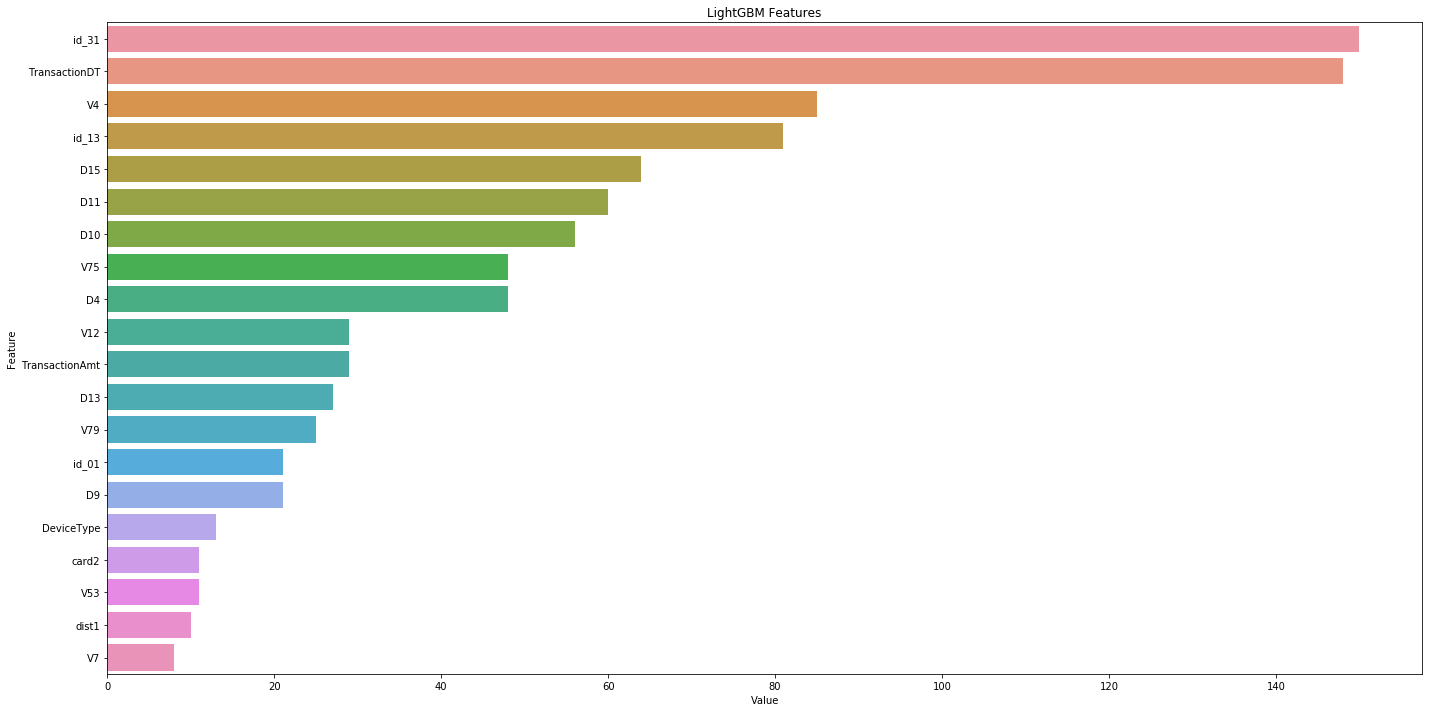

<Figure size 432x288 with 0 Axes>

In [19]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

Seems that transaction date is the main "culprit".

Let's see what happens when we remove time stamp.

In [20]:
del train, test, clf
gc.collect()

train = pd.read_csv('../input/standalone-train-and-test-preprocessing/train.csv')


test = pd.read_csv('../input/standalone-train-and-test-preprocessing/test.csv')

features = test.columns[1:]
train = train[features]
test = test[features]

train['target'] = 0
test['target'] = 1

train_test = pd.concat([train, test], axis =0)

del train, test

target = train_test['target'].values

# Label Encoding
for f in object_columns:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_test[f].values) )
    train_test[f] = lbl.transform(list(train_test[f].values))
    
train, test = model_selection.train_test_split(train_test, test_size=0.33, random_state=42, shuffle=True)

train_y = train['target'].values
test_y = test['target'].values
del train['target'], test['target']
gc.collect()

train = lgb.Dataset(train, label=train_y)
test = lgb.Dataset(test, label=test_y)

clf = lgb.train(param, train, num_round, valid_sets = [train, test], verbose_eval=50, early_stopping_rounds = 50)



Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.896492	valid_1's auc: 0.894941
Did not meet early stopping. Best iteration is:
[50]	training's auc: 0.896492	valid_1's auc: 0.894941


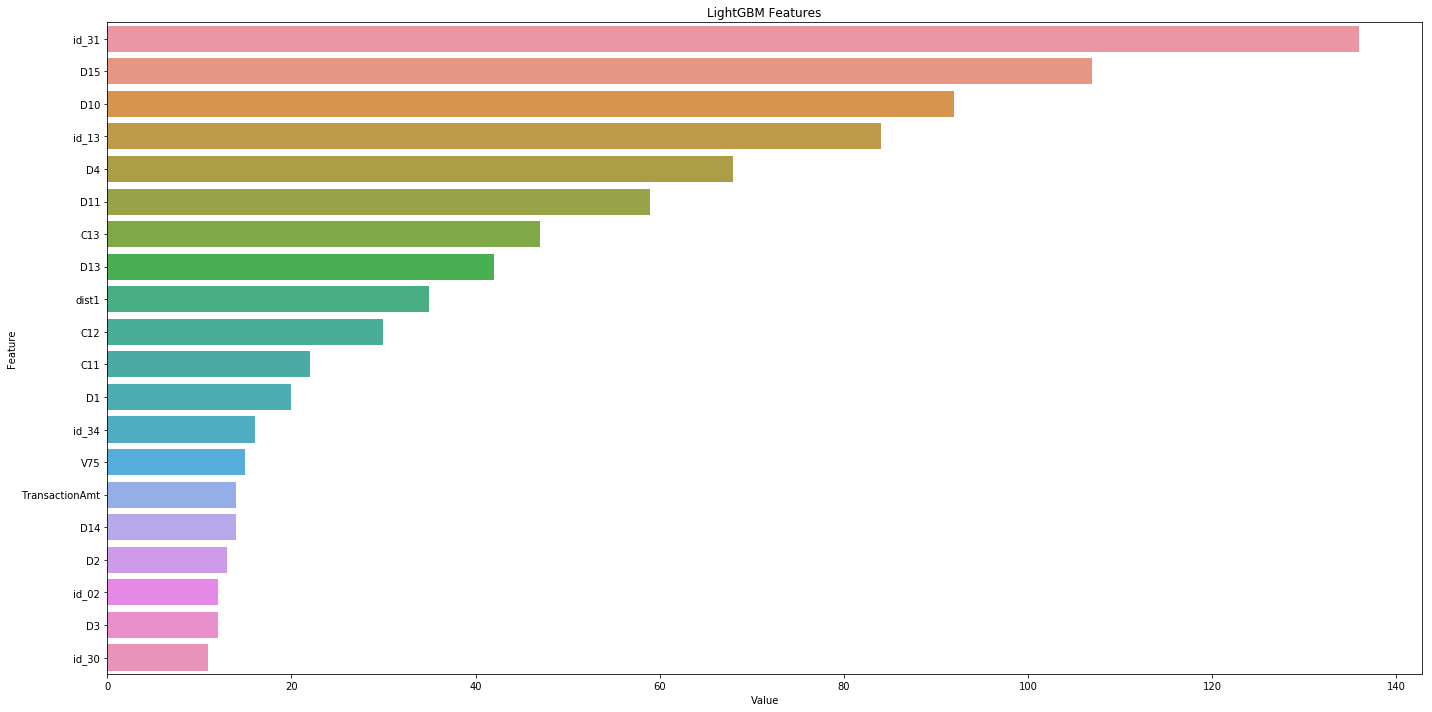

<Figure size 432x288 with 0 Axes>

In [21]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(),features)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

At 0.90 the AUC has improved, but it's still really high.

To be continued ...